In [551]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

## Overview

After a series of box office flops, the producers at your studio are starting to question their strategy and need some direction. You suggest a new approach - using data to determine what factors go into making a successful film. Luckily, you have a dataset of over 5000 films to mine for insights. Your producers ask you to spend some time analyzing the data and present a report detailing your findings, along with recommendations on how to revamp the studio’s strategy.

## How to define success
A successful movies can be defined as box office success, which can be 1.high gross or 2. high return per cost. A successful movies can be also critically acclaimed movies even though it doesn't necessarily succeed in the box office. In the context of project to achieve box office success, the success of a movie will be evaluated by return per cost, which is *gross per budget*.


## Loading and Exploring the Data

In [561]:
# read in the csv file
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm
from scipy import stats

from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score


movies_tb = pd.read_csv('/Users/zoeyzhang/Downloads/the_zebra_movie_data.csv')

In [562]:
movies_tb.columns 

Index(['color', 'director_name', 'num_critic_reviews', 'duration',
       'director_facebook_likes', 'actor_3_facebook_likes', 'actor_2_name',
       'actor_1_facebook_likes', 'gross', 'genres', 'actor_1_name',
       'movie_title', 'num_users_voted', 'cast_total_facebook_likes',
       'actor_3_name', 'plot_keywords', 'num_user_reviews', 'language',
       'country', 'content_rating', 'budget', 'title_year',
       'actor_2_facebook_likes', 'movie_score', 'aspect_ratio',
       'movie_facebook_likes'],
      dtype='object')

In [563]:
movies_tb['gross_per_budget'] = movies_tb['gross']/movies_tb['budget']

In [564]:
# print out some data
print('Data shape (rows, cols): ', movies_tb.shape)
print()
movies_tb.head()

Data shape (rows, cols):  (5043, 27)



,color,director_name,num_critic_reviews,duration,director_facebook_likes,actor_3_facebook_likes,actor_2_name,actor_1_facebook_likes,gross,genres,...,language,country,content_rating,budget,title_year,actor_2_facebook_likes,movie_score,aspect_ratio,movie_facebook_likes,gross_per_budget
0,Color,James Cameron,723.0,178.0,0.0,855.0,Joel David Moore,1000.0,760505847.0,Action|Adventure|Fantasy|Sci-Fi,...,English,USA,PG-13,237000000.0,2009.0,936.0,7.9,1.78,33000,3.208885
1,Color,Gore Verbinski,302.0,169.0,563.0,1000.0,Orlando Bloom,40000.0,309404152.0,Action|Adventure|Fantasy,...,English,USA,PG-13,300000000.0,2007.0,5000.0,7.1,2.35,0,1.031347
2,Color,Sam Mendes,602.0,148.0,0.0,161.0,Rory Kinnear,11000.0,200074175.0,Action|Adventure|Thriller,...,English,UK,PG-13,245000000.0,2015.0,393.0,6.8,2.35,85000,0.816629
3,Color,Christopher Nolan,813.0,164.0,22000.0,23000.0,Christian Bale,27000.0,448130642.0,Action|Thriller,...,English,USA,PG-13,250000000.0,2012.0,23000.0,8.5,2.35,164000,1.792523
4,NaN,Doug Walker,NaN,NaN,131.0,NaN,Rob Walker,131.0,NaN,Documentary,...,NaN,NaN,NaN,NaN,NaN,12.0,7.1,NaN,0,NaN


## Exploratory Data Analysis (EDA)
Now that we've loaded in the data, it is time to clean it up, explore it, and pre-process it. Data exploration is one of the most important parts because it allows you to notice any initial patterns in data distribution and features 

### Missing data investigation

In [565]:
print('Number of rows with complete data/no missing value: ', movies_tb.dropna(axis=0).shape[0])
print()

Number of rows with complete data/no missing value:  3761



### Outliers

In [566]:
# drop the rows of which 'gross' column is missing 
movies_tb = movies_tb[~movies_tb['gross'].isna()]
movies_tb = movies_tb[~movies_tb['budget'].isna()]

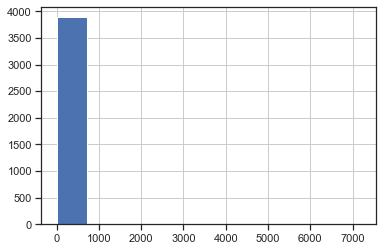

In [567]:
#histogram of gross per budget
movies_tb.gross_per_budget.hist()

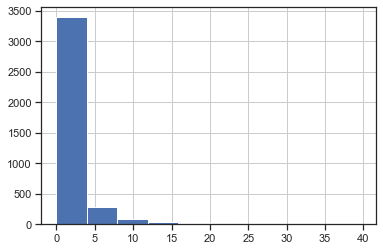

In [568]:
#histogram of gross per budget after removing outliers
movies_tb[movies_tb['gross_per_budget']<movies_tb['gross_per_budget'].quantile(0.99)].gross_per_budget.hist()

##### Remove outliers from the dataset and use the updated dataset from now on for the following reasons 
Staggering high return per budget movies are usually unreplicable, a product of luck and good work. Even there might be potentially an attribute indicative of a extremely high return, unfortunately, the features in the dataset might not be one of them and even it is, there are not enough number of the movies with top 1% gross per return in the dataset to study the pattern or relations between the attributes of interest and target 

In [569]:
# Remove outliers with top 1% gross per return 
movies_tb = movies_tb[movies_tb['gross_per_budget']<movies_tb['gross_per_budget'].quantile(0.99)]

### Features/factors might be indicative of successful movies 

I group all features in the following three categories 

In [570]:
review_features = ['num_critic_reviews', 'num_user_reviews',  'num_users_voted','movie_score']
                   
fb_features =  ['director_facebook_likes', 'actor_3_facebook_likes', 
                'actor_1_facebook_likes',  'cast_total_facebook_likes', 
                'actor_2_facebook_likes',  'movie_facebook_likes']

movie_features = ['color','duration', 'genres','plot_keywords', 'language', 'content_rating',
                  'title_year']

### movie features 

### title_year
Title year would play a important role in deciding the success of box office. In this dataset, there are some movies from 1950-2000. I decided not to include any movies that's made before 2000 for the following reasons. Firstly the viewer base has expanded over the past decades due to the increasing number of movie theaters,  income level and population.  Secondly the audience perference has shifted a lot over decades; Plus the movies before 2000 have a significant higher return compared to those made after 1990 as well.  Understanding what make movies before 2000 successful would not be too helpful for the movies in 2020s 

(0, 50)

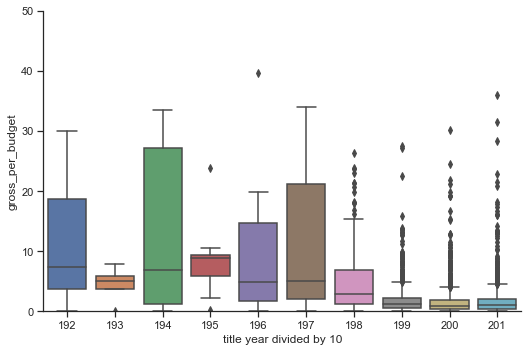

In [573]:
# drop any rows with missing data in column gross per budget and unknow title year 
movies_tb_short =  movies_tb[['gross_per_budget', 'title_year']].dropna()
# create a new column name year which is the floor of title year divided by 10 
movies_tb_short['year'] = (movies_tb_short['title_year'].astype(int)/10).astype(int)

#plot the box plot of distribution of return 
g = sns.catplot(x='year', y="gross_per_budget",
                data=movies_tb_short, kind="box",
                height=5, aspect=1.5);
g.set(xlabel = 'title year divided by 10')
g.axes[0,0].set_ylim([0,50])

In [464]:
movies_tb = movies_tb[movies_tb['title_year']>=2000]

### Genre 

In [468]:
#split genre by '|'
genres_series = movies_tb['genres'].apply(lambda x: x.split('|'))


#Obtain a set of unique genres
genres_set = set()
for genres in genres_series: 
    for genre in genres: 
        genres_set.add(genre)
genres_lst = list(genres_set)
genres_lst_final = []



In [469]:
#create a dataframe with two column genre of a movie and the gross, of which genre column has only one item

long_movie_genre_tb = pd.DataFrame({})

for genre in genres_lst: 
    movies_tb[genre] = movies_tb['genres'].apply(lambda x: 1 if genre in x else 0)  
    print('number of movies in the ' + genre + ' category:',  movies_tb[genre].value_counts()[1])
    
    if(movies_tb[genre].value_counts()[1] > 10): 
        genres_lst_final.append(genre)
        tmp = pd.DataFrame({'genre': genre, 'gross': movies_tb[movies_tb[genre] == 1]['gross'],
                            'gross_per_budget': movies_tb[movies_tb[genre] == 1]['gross_per_budget']}) 
        long_movie_genre_tb = long_movie_genre_tb.append(tmp)


number of movies in the Western category: 34
number of movies in the Animation category: 171
number of movies in the Musical category: 60
number of movies in the Sport category: 117
number of movies in the Drama category: 1418
number of movies in the Mystery category: 299
number of movies in the Horror category: 270
number of movies in the Adventure category: 573
number of movies in the Short category: 1
number of movies in the Documentary category: 59
number of movies in the Family category: 358
number of movies in the Romance category: 652
number of movies in the Comedy category: 1117
number of movies in the Biography category: 181
number of movies in the Action category: 688
number of movies in the Crime category: 510
number of movies in the Music category: 164
number of movies in the Thriller category: 809
number of movies in the Sci-Fi category: 346
number of movies in the History category: 111
number of movies in the War category: 116
number of movies in the Fantasy category: 374

(0, 5)

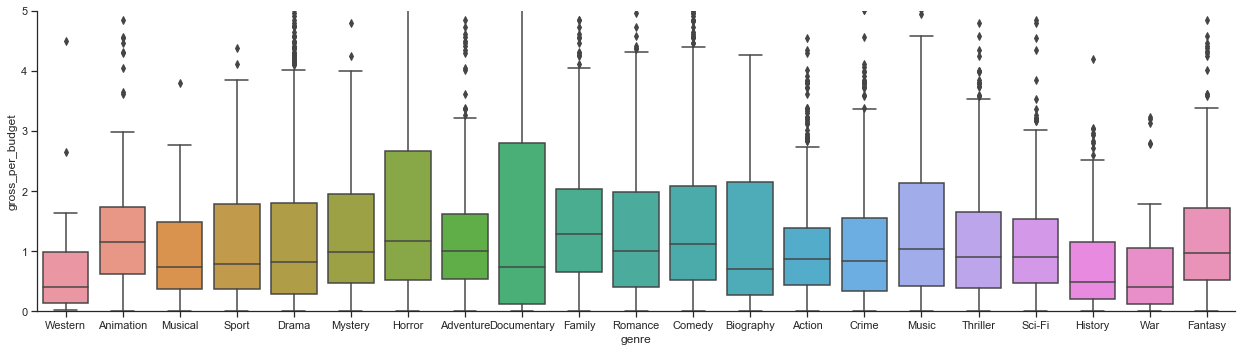

In [470]:
        
g = sns.catplot(x="genre", y="gross_per_budget",
                data=long_movie_genre_tb, kind="box",
                height=5, aspect=3.5);

g.axes[0,0].set_ylim([0,5])

### keywords 

In [471]:
#split KEYWORDS by '|'
keywords_series = movies_tb['plot_keywords'].astype('str').apply(lambda x: x.split('|'))

#Obtain list of unique keywords
keywords_dict = {}
for keywords in keywords_series: 
    for keyword in keywords: 
        if keyword in keywords_dict: 
            keywords_dict[keyword] += 1
        else: 
            keywords_dict[keyword] = 1

#sorted keywords by the number of occurances            
keywords_dict = sorted(keywords_dict.items(), key = lambda x: x[1], reverse=True)
#filter and remove keywords that occur <= 50 
keywords_dict = [keyword for keyword in keywords_dict if keyword[1]>50]
#print out keyword dictionary
keywords_dict

[('love', 112),
 ('friend', 97),
 ('murder', 88),
 ('death', 75),
 ('police', 61),
 ('new york city', 51)]

In [472]:
#add one hot encoded column for each frequent keyword to movies_tb, keyword is in plot keywords 
# if value = 1 otherwise value =0 
keyword_boxplot_tb = pd.DataFrame({})
for item in keywords_dict:
    movies_tb[item[0]] = movies_tb['plot_keywords'].apply(lambda x: True if item[0] in str(x) else False)
    keyword_boxplot_tb = keyword_boxplot_tb.append(pd.DataFrame({'keyword': item[0], 
                                            'gross_per_budget': movies_tb[movies_tb[item[0]]]['gross_per_budget']}))


Text(0.5, 1, 'boxplot group by the keywords of which the number of occurances > 50')

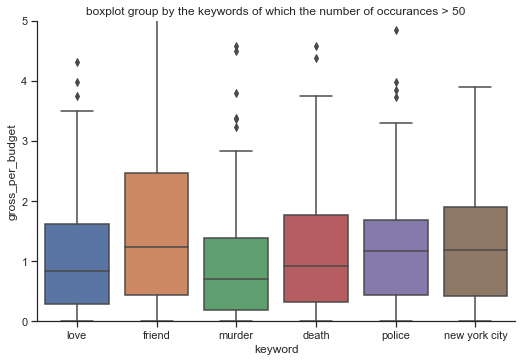

In [547]:
g = sns.catplot(x="keyword", y="gross_per_budget",
                data=keyword_boxplot_tb, kind="box",
                height=5, aspect=1.5)
g.axes[0,0].set_ylim([0,5])
g.axes[0,0].set_title('boxplot group by the keywords of which the number of occurances > 50')

### content_rating

In [549]:
movies_tb['content_rating'].value_counts().reset_index(name = 'count')

,index,count
0,R,1163
1,PG-13,1095
2,PG,390
3,G,54
4,Unrated,50
5,nan,40
6,NC-17,3


In [550]:
# replace not rated with rated to decrease feature dimension 
movies_tb['content_rating'] = movies_tb['content_rating'].apply(lambda x: str(x).replace('Not Rated', 'Unrated'))

Text(0.5, 1, 'boxplot group by content_rating')

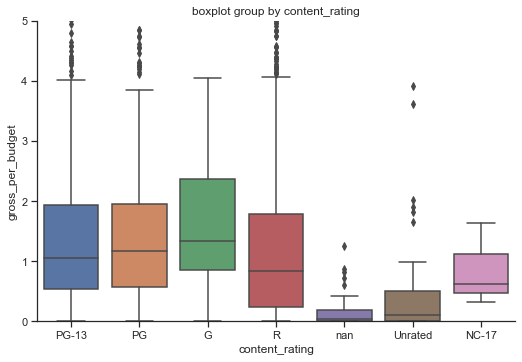

In [548]:

g = sns.catplot(x="content_rating", y="gross_per_budget",
                data=movies_tb, kind="box",
                height=5, aspect=1.5);
g.axes[0,0].set_ylim([0,5])
g.axes[0,0].set_title('boxplot group by content_rating')

### Country
Films that's made in English speaking countries display a higher revenue per budget

In [575]:
movies_tb['country'].value_counts()[:10].reset_index()

,index,country
0,USA,3038
1,UK,325
2,France,106
3,Germany,82
4,Canada,63
5,Australia,41
6,Spain,22
7,Japan,17
8,China,15
9,India,14


(0, 5)

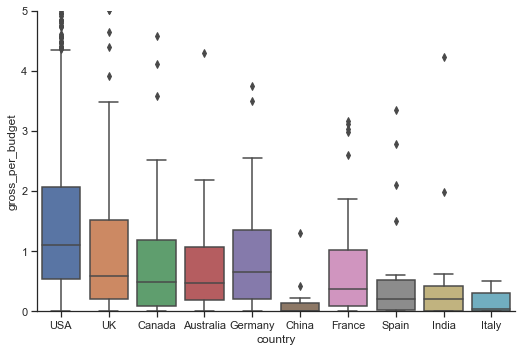

In [478]:
movies_tb_country = movies_tb[movies_tb['country'].isin(['USA', 'UK', 'France', 'Canada', 'Germany', 'Australia', 'India',
       'Spain', 'China', 'Italy'])]
g = sns.catplot(x="country", y="gross_per_budget",
                data=movies_tb_country, kind="box",
                height=5, aspect=1.5);
g.axes[0,0].set_ylim([0,5])

### Language 

In [479]:
movies_tb['language'].value_counts().reset_index().head(10)

,index,language
0,English,2671
1,French,31
2,Spanish,23
3,Mandarin,15
4,Hindi,10
5,German,9
6,Cantonese,6
7,Japanese,6
8,Korean,5
9,Portuguese,4


In [480]:
movies_tb['language'].iloc[0] == 'English'

True

In [481]:
movies_tb['if_english'] = movies_tb['language'].apply(lambda x: True if x == 'English' else False)

Films in English are more likely to do well than non English film

(0, 5)

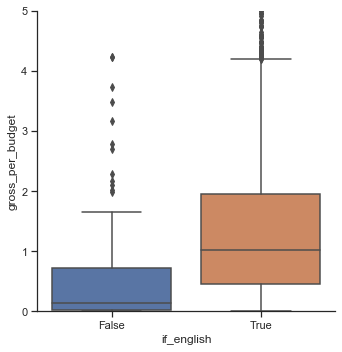

In [482]:
g = sns.catplot(x="if_english", y="gross_per_budget",
                data=movies_tb, kind="box",
                height=5, aspect=1);
g.axes[0,0].set_ylim([0,5])

### duration

(0, 20)

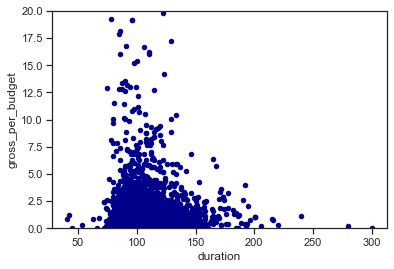

In [483]:
movies_tb_2000 = movies_tb[movies_tb['title_year'] > 2000]
ax = movies_tb.plot.scatter(x='duration', y='gross_per_budget', c='DarkBlue')
ax.set_ylim([0,20])

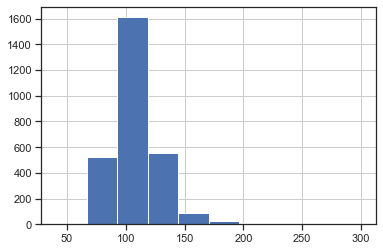

In [484]:
movies_tb.duration.hist()

### Color 
Color columns has three unique value, 'color', nan, or 'black and white'. Movies from 1950 or earlier are black and white, therefore the variable is highly correlated with title year. Since we have already removed the movies made before 2000, it's safe to assume the color is made black and white for cinematographic reasons.  Black and white movies seems have lower return per budget on average

In [485]:
movies_tb['color'].unique()

array(['Color', 'Black and White', nan], dtype=object)

(0, 5)

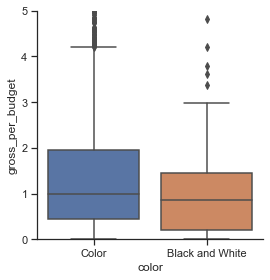

In [486]:
g = sns.catplot(x="color", y="gross_per_budget",
                data=movies_tb_country, kind="box",
                height=4, aspect=1);
g.axes[0,0].set_ylim([0,5])

### review_features
The level of control any film company over reviews can be small. Any film company, if possible, they will try to make films that will lead to more critical reviews, higher review score, more reviews from users. Also, when it comes to film review, the causation is more likely to be the success of movies helps better review and more reviews, less likely to be the other way around. Since in this task, we aim to find factors that ‘cause’ or ‘help’ box office success, review features will not be considered.

['num_critic_reviews', 'num_user_reviews', 'num_users_voted', 'movie_score']

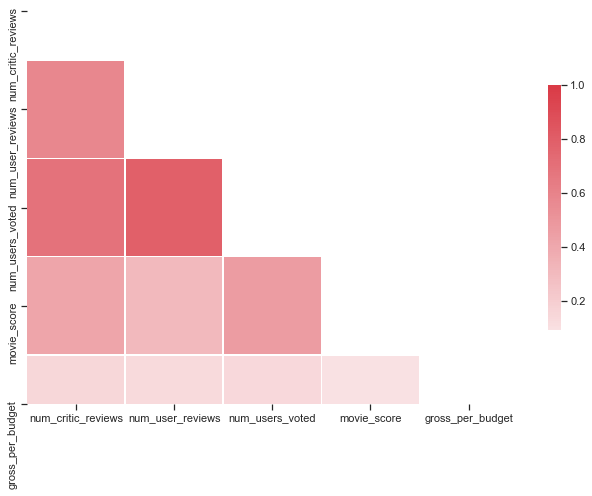

In [487]:

feature_set = review_features[:]
feature_set.append('gross_per_budget')
corr_heatmap(movies_tb[feature_set])
sns.set(style="ticks", color_codes=True)
review_features[:]



### Facebook likes features 
There are couple columns related to facebook likes, 'director facebook likes', 'actor_1_facebook_likes','actor_2_facebook_likes','actor_3_facebook_likes',  'movie_facebook_likes',  'cast_total_facebook_likes'. *Movie facebook likes factor will not be considered since it’s less likely controlled by movie company and the success of the movies is more likely lead to higher number of movie likes*. There is no significant correlations except for movie facebook likes between facebook likes and gross_per_revenue according to scatterplot and heatmap 


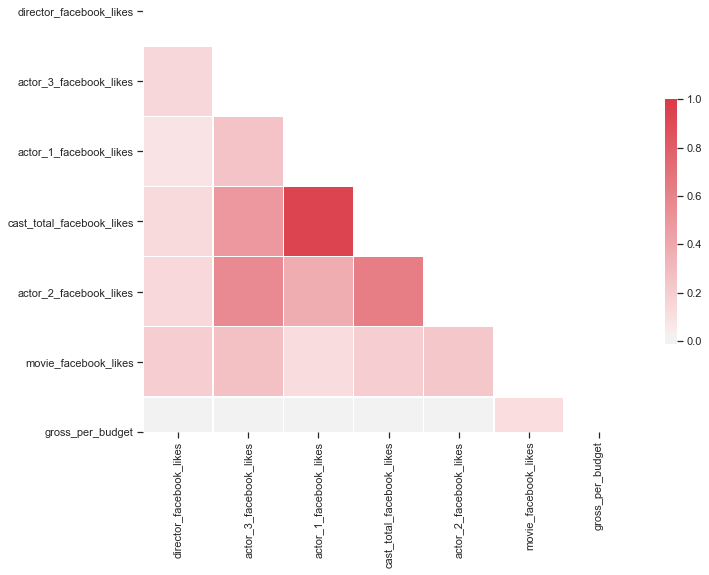

In [489]:

import numpy as np
def corr_heatmap(d):
    corr = d.corr()

    # Generate a mask for the upper triangle
    mask = np.triu(np.ones_like(corr, dtype=np.bool))
    
    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=(11, 9))

    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(220, 10, as_cmap=True)

    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
            
            
feature_set = fb_features[:]
feature_set.append('gross_per_budget')
corr_heatmap(movies_tb[feature_set])


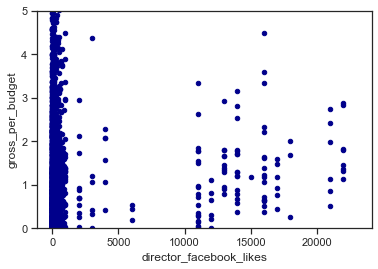

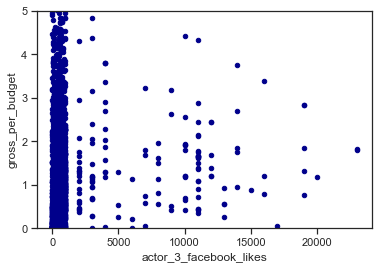

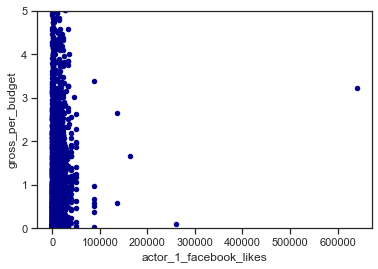

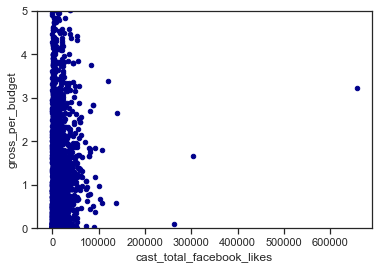

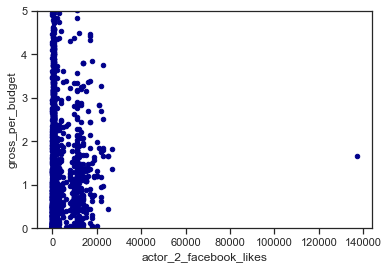

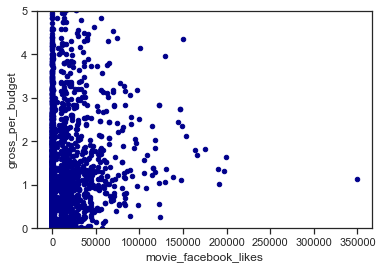

In [394]:

sns.set(style="ticks", color_codes=True)
review_features[:]

for f in fb_features: 
    try:
        ax = movies_tb.plot.scatter(x=f, y='gross_per_budget', c='DarkBlue')
        #ax.set_xscale('log')
        ax.set_ylim([0,5])
    except:
        print(f)

## Linear regression

### Model Overview
In order to decide the factors that will give the movies higher chance of box office success, which in the task is defined as high gross per budget, we list the features that film company can consider and use a linear regression to test if any of the factors will improve the movie in a statistically significant level


### Features
#### 1. facebook features: 
1. facebook cast likes number  
2. director total likes. \
Note, facebook movie total likes will not be considered in the model since movies likes cannot be controlled by the company, and the number of facebook likes might be correlated and impacted by gross per budget

#### 2. movie features: 
1. movie content rating: R, PG-13, PG, G, Unrated, NC-17
2. movie genre: 'Western', 'Animation', 'Musical', 'Sport', 'Drama', 'Mystery','Horror', 'Adventure', 'Documentary', 'Family', 'Romance', 'Comedy', 'Biography', 'Action', 'Crime', 'Music', 'Thriller','Sci-Fi', 'History', 'War', 'Fantasy',
3. key words: 'love', 'friend', 'murder', 'death', 'police', 'new york city', 'if_school', 'Other'
4. Others: 
    1. movie color: black white and color
    2. language: English or non-English 
    3. duration 



In [522]:
genres = [ 'Western', 'Animation',
       'Musical', 'Sport', 'Drama', 'Mystery', 'Horror', 'Adventure', 
       'Documentary', 'Family', 'Romance', 'Comedy', 'Biography', 'Action',
       'Crime', 'Music', 'Thriller', 'Sci-Fi', 'History', 'War', 'Fantasy']
keywords = ['love', 'friend', 'murder', 'death', 'police', 'new york city']
ratings = ['rating_G', 'rating_NC-17', 'rating_PG', 'rating_PG-13', 'rating_R']
fb_features = [ 'director_facebook_likes', 'cast_total_facebook_likes']
others = ['if_english', 'duration', 'if_color']


#### Data Prep for modeling 
1. drop missing row 
2. one hot encoding 'color' and content rating column 

In [552]:
movies_tb['if_color'] = movies_tb['color'].apply(lambda x: True if x=='Color' else False)
movies_tb = pd.get_dummies(movies_tb, columns=["content_rating"], prefix=["rating"] )
movies_tb_complete = movies_tb.dropna()

#### Models and results 
Rating, keywords and movie genres have a high correlations. To avoid multicolliearity I will create four models will different set of features \
No.1 All features \
No.2 All features except for genres and rating \
No.3 All features except for rating and keywords\
No.4 All features except for keywords and genres

In [553]:
def LinearLearner(features): 
    """Input features and return a linear regression summary with the subset of features of input 
    and y = 'gross_per_budget'
    """
    X = movies_tb_complete[features]
    y =  movies_tb_complete.gross_per_budget
    X2 = sm.add_constant(X)
    est = sm.OLS(y, X2.astype(float))
    est2 = est.fit()
    print(est2.summary())

In [554]:
def CreateFeatureSet(genres=True, keywords=True, rating=True, fb_features=True, others = True): 
    """This method returns sebset features of your selection for modeling 
    @genres: if genres feature included 
    @keywords: if keyword feature included 
    @rating: if rating feature will be included in the feature set 
    @fb_features: if facebook feature will be included in the feature set 
    @others: if others will be included 
    """
    type_f = {'genres': genres, 'keywords':keywords, 'ratings': rating, 'fb_features': fb_features, 'others':others}
    feature_set = []
    for key, value in type_f.items(): 
        if(value): 
            feature_set.extend(globals()[key])
    return(feature_set)

In [555]:
# include all features 
feature_set = CreateFeatureSet()
LinearLearner(feature_set)

                            OLS Regression Results                            
Dep. Variable:       gross_per_budget   R-squared:                       0.075
Model:                            OLS   Adj. R-squared:                  0.062
Method:                 Least Squares   F-statistic:                     5.851
Date:                Tue, 19 May 2020   Prob (F-statistic):           5.76e-26
Time:                        12:37:34   Log-Likelihood:                -5140.1
No. Observations:                2708   AIC:                         1.036e+04
Df Residuals:                    2670   BIC:                         1.058e+04
Df Model:                          37                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                 

/usr/local/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


In [556]:
# include only genres 
feature_set = CreateFeatureSet(genres=True, rating=False, keywords= False)
LinearLearner(feature_set)

                            OLS Regression Results                            
Dep. Variable:       gross_per_budget   R-squared:                       0.062
Model:                            OLS   Adj. R-squared:                  0.053
Method:                 Least Squares   F-statistic:                     6.817
Date:                Tue, 19 May 2020   Prob (F-statistic):           1.50e-23
Time:                        12:37:35   Log-Likelihood:                -5159.0
No. Observations:                2708   AIC:                         1.037e+04
Df Residuals:                    2681   BIC:                         1.053e+04
Df Model:                          26                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                 

In [557]:
# include only ratings 
feature_set = CreateFeatureSet(genres=False, rating=True, keywords= False)
LinearLearner(feature_set)

                            OLS Regression Results                            
Dep. Variable:       gross_per_budget   R-squared:                       0.015
Model:                            OLS   Adj. R-squared:                  0.011
Method:                 Least Squares   F-statistic:                     4.052
Date:                Tue, 19 May 2020   Prob (F-statistic):           1.52e-05
Time:                        12:37:36   Log-Likelihood:                -5225.5
No. Observations:                2708   AIC:                         1.047e+04
Df Residuals:                    2697   BIC:                         1.054e+04
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                 

In [558]:
# include only keywords 
feature_set = CreateFeatureSet(genres=False, rating=False, keywords=True)
LinearLearner(feature_set)

                            OLS Regression Results                            
Dep. Variable:       gross_per_budget   R-squared:                       0.013
Model:                            OLS   Adj. R-squared:                  0.009
Method:                 Least Squares   F-statistic:                     3.234
Date:                Tue, 19 May 2020   Prob (F-statistic):           0.000213
Time:                        12:37:36   Log-Likelihood:                -5227.9
No. Observations:                2708   AIC:                         1.048e+04
Df Residuals:                    2696   BIC:                         1.055e+04
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                 